### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [236]:
data = pd.read_csv("../data/processed_train.csv")

In [237]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [238]:
### Your code is here

print(data[data['HasDetections'] == 0].shape[0])
print(data[data['HasDetections'] == 1].shape[0])


99940
20012


Произведем процедуру отложенной выборки:

In [239]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [240]:
### Your code is here

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(penalty='l2'))
])


In [241]:
pipe.set_params(LR__C=0.01)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(C=0.01))])

In [242]:
from sklearn.model_selection import cross_validate

custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]

cv_result = cross_validate(pipe, X, y,
                           cv=custom_cv, 
                           scoring='accuracy',
                           return_train_score=True)

print(f"Accuracy на трейне: {np.mean(cv_result['train_score'].round(3))}")
print(f"Accuracy на тесте: {np.mean(cv_result['test_score'].round(3))}")

Accuracy на трейне: 0.841
Accuracy на тесте: 0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [243]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here

# Получение предсказанных меток классов на тестовой выборке
pred_test = pipe.predict(X_test)

# Создание пустой матрицы ошибок
num_classes = len(np.unique(y_test))
confusion_matrix = np.zeros((num_classes, num_classes))

# Заполнение матрицы ошибок
for i in range(len(y_test)):
    true_class = y_test.iloc[i]  # или y_test.values[i]
    pred_class = pred_test[i]
    confusion_matrix[true_class, pred_class] += 1

print(confusion_matrix)




[[24727.   292.]
 [ 4442.   527.]]


In [244]:
from sklearn.metrics import confusion_matrix

### Your code is here

tn, fp, fn, tp = confusion_matrix(y_test, pipe.predict(X_test)).ravel()

confusion_matrix = np.array([[tn, fp], [fn, tp]])

confusion_matrix


array([[24727,   292],
       [ 4442,   527]], dtype=int64)

**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [245]:
### Your code is here

accuracy = (tp + tn) / (tp + tn + fp + fn)

print(round(accuracy, 3))

0.842


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [246]:
from sklearn.metrics import recall_score, precision_score

### Your code is here

recall = recall_score(y_test, pipe.predict(X_test))
precision = precision_score(y_test, pipe.predict(X_test))

print(f"recall: {round(recall, 3)}")
print(f"precision: {round(precision, 3)}")


recall: 0.106
precision: 0.643


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [247]:
# Получение предсказанных вероятностей с помощью метода predict_proba
pred_probs = pipe.predict_proba(X_test)

# Преобразование вероятностей в вектор предсказаний с порогом 0.5
predicted_labels = (pred_probs[:, 1] >= 0.5).astype(int)

# Сравнение предсказанных меток с истинными значениями из y_test
accuracy = (predicted_labels == y_test).mean()
print("Accuracy:", accuracy)


Accuracy: 0.8421368547418968


In [248]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

pred_probs = pipe.predict_proba(X_test)
pred_probs = (pred_probs[:, 1]>= 0.5).astype(int)

recall_prob = recall_score(y_test, pred_probs)
precision_prob = precision_score(y_test, pred_probs)
accuracy_prob = accuracy_score(y_test, pred_probs)

print(recall_prob, precision_prob, accuracy_prob)

0.10605755685248541 0.6434676434676435 0.8421368547418968


In [249]:
### Your code is here

from sklearn.metrics import precision_recall_curve

precision, recall, thres = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:, 1])

ind = np.where(recall == recall[precision > 0.5].max())

print("recall:", recall[ind])
print("precision:", precision[ind])

recall: [0.19339907 0.19339907 0.19339907 0.19339907 0.19339907]
precision: [0.49922078 0.49948025 0.49973999 0.5        0.50026028]


**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [250]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

pred_probs = pipe.predict_proba(X_test)

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003734827264239
Recall: 	 0.12940229422418997
Threshold:	 0.45894877437904197


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [251]:
### Your code is here

from sklearn.metrics import precision_recall_curve

pred_probs = pipe.predict_proba(X_test)

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

print(precision, recall, thres)

### Находим такую тройку, при которой precision максимален, а recall > 0.2

ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precision:\t {round(precision[ind][-1], 5)}")
print(f"Recall: \t {round(recall[ind][-1], 5)}")
print(f"Threshold:\t {round(thres[ind][-1], 5)}")

[0.16569961 0.16570514 0.16571066 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 4.02495472e-04
 2.01247736e-04 0.00000000e+00] [7.52139047e-05 9.79851366e-04 1.33018965e-03 ... 8.98350820e-01
 9.12532491e-01 9.16701473e-01]
Precision:	 0.49282
Recall: 	 0.20024
Threshold:	 0.33129


In [252]:
print(len(precision), len(recall), len(thres))

29988 29988 29987


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [253]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma')

Precision:	 0.16993934409375963
Recall: 	 0.9979875226403703
Threshold:	 0.021913348366451868


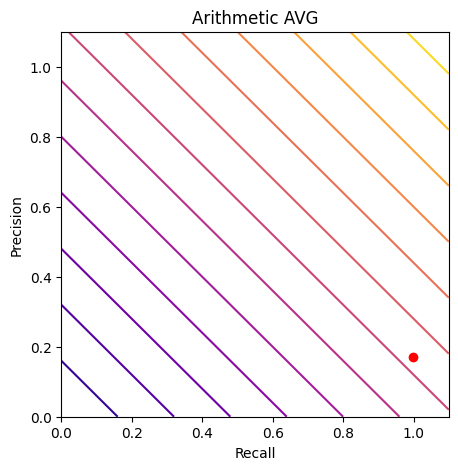

In [254]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	 0.22388
Recall: 	 0.80942
Threshold:	 0.12601


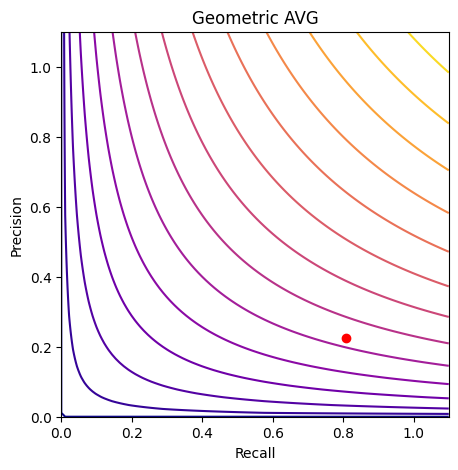

In [255]:
### Повторите для среднего геометрического
### Your code is here

metric_func = lambda x, y: (x * y)**0.5

geom_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {round(precision[geom_idx], 5)}")
print(f"Recall: \t {round(recall[geom_idx], 5)}")
print(f"Threshold:\t {round(thres[geom_idx], 5)}")

level_lines(metric_func, "Geometric AVG")
plt.plot(recall[geom_idx], precision[geom_idx], 'ro');

Precision:	 0.359
Recall: 	 0.359
Threshold:	 0.237


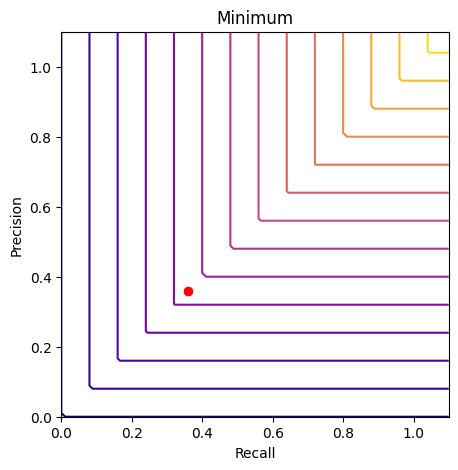

In [256]:
### Повторите для минимума
### Your code is here

# Определяем функцию, вычисляющую минимум между точностью и полнотой
metric_func_min = lambda x, y: np.minimum(x, y)

# Индекс минимума между точностью и полнотой
min_idx = np.argmax(metric_func_min(precision, recall))

# Выводим значения точности, полноты и порога, соответствующие минимуму
print(f"Precision:\t {round(precision[min_idx], 3)}")
print(f"Recall: \t {round(recall[min_idx], 3)}")
print(f"Threshold:\t {round(thres[min_idx], 3)}")

# Рисуем уровни функции
level_lines(metric_func_min, "Minimum")
plt.plot(recall[min_idx], precision[min_idx], 'ro');


**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.285
Recall: 	 0.524
Threshold:	 0.193
F-score:	 0.369


C:\Users\danil\AppData\Local\Temp\ipykernel_7884\2204178754.py:5: RuntimeWarning: invalid value encountered in divide
  metric_func_min = lambda x, y: (1 + beta_sqr) * (x * y) / ((beta_sqr * x) + y)


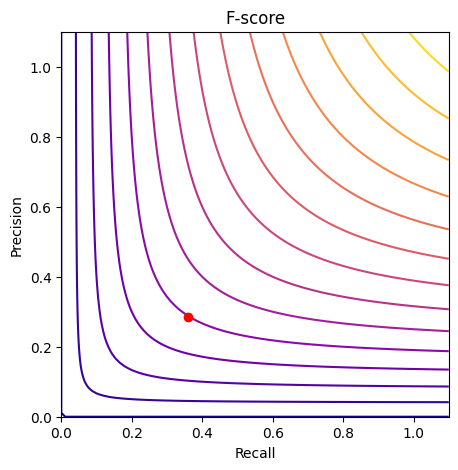

In [257]:
# Определяем функцию, вычисляющую минимум между точностью и полнотой

beta_sqr = 1

metric_func_min = lambda x, y: (1 + beta_sqr) * (x * y) / ((beta_sqr * x) + y)

# Индекс минимума между точностью и полнотой
f_idx = np.argmax(metric_func_min(precision, recall))

# Выводим значения точности, полноты и порога, соответствующие минимуму
print(f"Precision:\t {round(precision[f_idx], 3)}")
print(f"Recall: \t {round(recall[f_idx], 3)}")
print(f"Threshold:\t {round(thres[f_idx], 3)}")
print(f"F-score:\t {round(metric_func_min(precision[f_idx], recall[f_idx]), 3)}")

# Рисуем уровни функции
level_lines(metric_func_min, "F-score")
plt.plot(recall[min_idx], precision[f_idx], 'ro');

F-score: 	 0.369
Precision: 	 0.285
Recall: 	 0.524
Threshold: 	 0.193


C:\Users\danil\AppData\Local\Temp\ipykernel_7884\750399915.py:4: RuntimeWarning: invalid value encountered in divide
  f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr) * (p * r) / ((beta_sqr * p) + r)


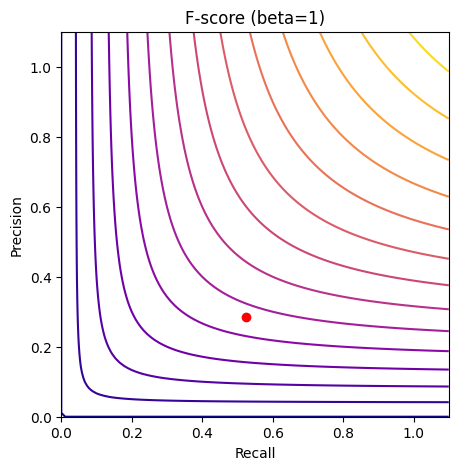

In [258]:
beta_sqr = 1  # Задаем значение параметра beta

# Определяем функцию, вычисляющую F-меру
f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr) * (p * r) / ((beta_sqr * p) + r)

# Вычисляем F-меру для каждой пары значений точности и полноты
f_scores = f_score_func(precision, recall, beta_sqr)

# Индекс максимальной F-меры
max_f_idx = np.argmax(f_scores)

# Выводим значение F-меры, точности, полноты и порога, соответствующие максимальной F-мере
print(f"F-score: \t {round(f_scores[max_f_idx], 3)}")
print(f"Precision: \t {round(precision[max_f_idx], 3)}")
print(f"Recall: \t {round(recall[max_f_idx], 3)}")
print(f"Threshold: \t {round(thres[max_f_idx], 3)}")

# Рисуем уровни функции
level_lines(lambda x, y: f_score_func(x, y, beta_sqr), f"F-score (beta={beta_sqr})")
plt.plot(recall[max_f_idx], precision[max_f_idx], 'ro');

F-score: 	 0.392
Precision: 	 0.533
Recall: 	 0.18
Threshold: 	 0.362


C:\Users\danil\AppData\Local\Temp\ipykernel_7884\1772326115.py:8: RuntimeWarning: invalid value encountered in divide
  f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr**0.5) * (p * r) / ((beta_sqr**0.5 * p) + r)


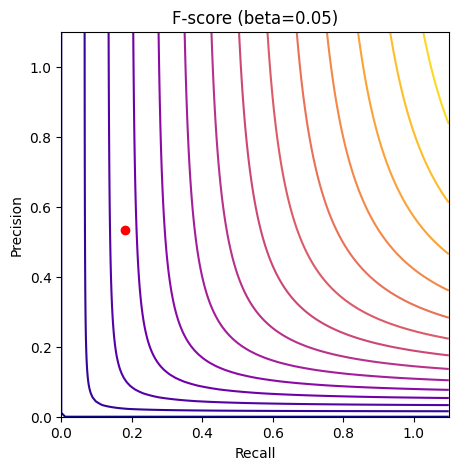

In [259]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

beta_sqr = 0.05  # Задаем значение параметра beta

# Определяем функцию, вычисляющую F-меру
f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr**0.5) * (p * r) / ((beta_sqr**0.5 * p) + r)

# Вычисляем F-меру для каждой пары значений точности и полноты
f_scores = f_score_func(precision, recall, beta_sqr)

# Индекс максимальной F-меры
max_f_idx = np.argmax(f_scores)

# Выводим значение F-меры, точности, полноты и порога, соответствующие максимальной F-мере
print(f"F-score: \t {round(f_scores[max_f_idx], 3)}")
print(f"Precision: \t {round(precision[max_f_idx], 3)}")
print(f"Recall: \t {round(recall[max_f_idx], 3)}")
print(f"Threshold: \t {round(thres[max_f_idx], 3)}")

# Рисуем уровни функции
level_lines(lambda x, y: f_score_func(x, y, beta_sqr), f"F-score (beta={beta_sqr})")
plt.plot(recall[max_f_idx], precision[max_f_idx], 'ro');


F-score: 	 0.435
Precision: 	 0.236
Recall: 	 0.754
Threshold: 	 0.141


C:\Users\danil\AppData\Local\Temp\ipykernel_7884\4179193688.py:8: RuntimeWarning: invalid value encountered in divide
  f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr**0.5) * (p * r) / ((beta_sqr**0.5 * p) + r)


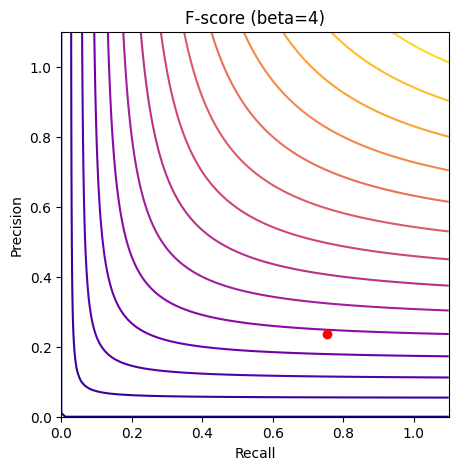

In [260]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

beta_sqr = 4  # Задаем значение параметра beta

# Определяем функцию, вычисляющую F-меру
f_score_func = lambda p, r, beta_sqr: (1 + beta_sqr**0.5) * (p * r) / ((beta_sqr**0.5 * p) + r)

# Вычисляем F-меру для каждой пары значений точности и полноты
f_scores = f_score_func(precision, recall, beta_sqr)

# Индекс максимальной F-меры
max_f_idx = np.argmax(f_scores)

# Выводим значение F-меры, точности, полноты и порога, соответствующие максимальной F-мере
print(f"F-score: \t {round(f_scores[max_f_idx], 3)}")
print(f"Precision: \t {round(precision[max_f_idx], 3)}")
print(f"Recall: \t {round(recall[max_f_idx], 3)}")
print(f"Threshold: \t {round(thres[max_f_idx], 3)}")

# Рисуем уровни функции
level_lines(lambda x, y: f_score_func(x, y, beta_sqr), f"F-score (beta={beta_sqr})")
plt.plot(recall[max_f_idx], precision[max_f_idx], 'ro');
